In [ ]:

! pip install -q scikit-learn pandas numpy joblib tldextract matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest

import tldextract

# Optional: silence a few noisy warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
class UrlNumericFeatures(BaseEstimator, TransformerMixin):
    """
    Lightweight, high-signal numeric features + brand-domain consistency flags.
    """
    def __init__(self):
        self.suspicious = [
            "login","signin","secure","account","update","verify","bank",
            "confirm","wp-content","paypal","ebay","amazon","apple","google",
            "microsoft","facebook","netflix","adobe"
        ]
        self.brands = ["paypal","google","amazon","microsoft","apple",
                       "facebook","netflix","adobe","bank","ebay"]
        self.ip_pattern = re.compile(r"(^|://)?(\d{1,3}(?:\.\d{1,3}){3})(:\d+)?(/|$)")

    # ---- helpers ----
    def _strip_scheme_host(self, url):
        # remove scheme
        s = re.split(r'^[a-zA-Z][a-zA-Z0-9+.-]*://', str(url), maxsplit=1)[-1]
        return s

    def _host_only(self, url):
        s = self._strip_scheme_host(url)
        return s.split('/', 1)[0].split(':', 1)[0]

    def _path_depth(self, url):
        s = self._strip_scheme_host(url)
        path = s.split('/', 1)[1] if '/' in s else ''
        return len([p for p in path.split('/') if p])

    def _num_query_params(self, url):
        if '?' not in url: return 0
        query = url.split('?', 1)[1].split('#', 1)[0]
        if not query: return 0
        return sum(1 for kv in query.split('&') if kv.strip() != '')

    def _num_subdomains(self, url):
        host = self._host_only(url)
        if self.ip_pattern.search(host):
            return 0
        parts = [p for p in host.split('.') if p]
        return max(0, len(parts) - 2)

    def _tld_length(self, url):
        host = self._host_only(url)
        ext = tldextract.extract(host)
        suffix = ext.suffix or ""
        return len(suffix.split('.')[-1]) if suffix else 0

    def _registered_domain(self, url):
        host = self._host_only(url)
        ext = tldextract.extract(host)
        # Use the new name to avoid deprecation warnings:
        reg = ext.top_domain_under_public_suffix or host
        return reg.lower()

    def _brand_flags(self, url):
        u = str(url).lower()
        reg = self._registered_domain(url)
        brand_in_domain = int(any(b in reg for b in self.brands))
        brand_in_path_only = int(any(b in u for b in self.brands) and not brand_in_domain)
        return brand_in_domain, brand_in_path_only

    # ---- sklearn API ----
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        urls = pd.Series(X.iloc[:,0] if isinstance(X, pd.DataFrame) else X).astype(str)

        url_length = urls.str.len().fillna(0).astype(int).values
        num_dots = urls.str.count(r"\.").values
        num_hyphens = urls.str.count(r"-").values
        num_at = urls.str.count(r"@").values
        has_ip = urls.apply(lambda u: 1 if self.ip_pattern.search(self._host_only(u)) else 0).values
        path_depth = urls.apply(self._path_depth).values
        num_query_params = urls.apply(self._num_query_params).values
        num_subdomains = urls.apply(self._num_subdomains).values
        suspicious_count = urls.apply(lambda u: sum(1 for k in self.suspicious if k in u.lower())).values
        tld_len = urls.apply(self._tld_length).values
        brand_in_domain, brand_in_path_only = zip(*urls.apply(self._brand_flags))
        brand_in_domain = np.array(brand_in_domain)
        brand_in_path_only = np.array(brand_in_path_only)

        return np.column_stack([
            url_length, num_dots, num_hyphens, num_at, has_ip,
            path_depth, num_query_params, num_subdomains,
            suspicious_count, tld_len, brand_in_domain, brand_in_path_only
        ])

def make_preprocessor():
    # Optimized TF-IDF: safe on 500k+ rows, strong accuracy
    tfidf = TfidfVectorizer(
        analyzer="char",
        ngram_range=(3,4),
        min_df=5,
        max_features=50000,
        strip_accents="unicode"
    )
    return ColumnTransformer(
        transformers=[
            ("tfidf", tfidf, "URL"),
            ("num", UrlNumericFeatures(), "URL"),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

# Toggle if you need probabilities (slower): True => uses Calibrated LinearSVC
USE_CALIBRATION = False

def make_supervised_pipeline():
    prep = make_preprocessor()
    if USE_CALIBRATION:
        base = LinearSVC()
        clf = CalibratedClassifierCV(base, cv=3)
    else:
        clf = LinearSVC()
    return Pipeline([("prep", prep), ("clf", clf)])

def make_oneclass_pipeline():
    prep = make_preprocessor()
    oc = IsolationForest(n_estimators=300, contamination=0.15, random_state=42)
    return Pipeline([("prep", prep), ("oc", oc)])


In [4]:
# <<< EDIT THIS PATH >>>
CSV_PATH = "phishing_site_urls.csv"   # put your CSV path here (same folder as notebook)

df = pd.read_csv(CSV_PATH)
assert "URL" in df.columns and "Label" in df.columns, "CSV must have columns: URL, Label"

df["Label"] = df["Label"].astype(str).str.strip().str.lower()
print(df.head())
print("Rows:", len(df))
print("Labels:", df["Label"].value_counts().to_dict())


                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
Rows: 549346
Labels: {'good': 392924, 'bad': 156422}


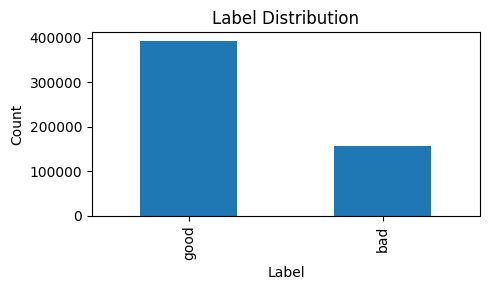

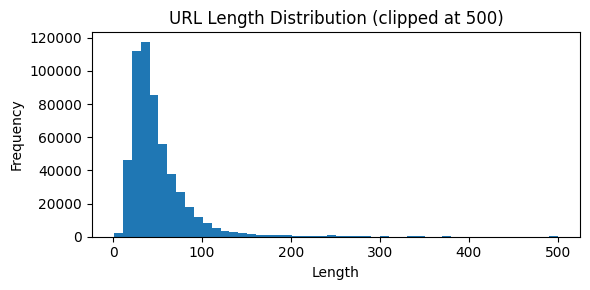

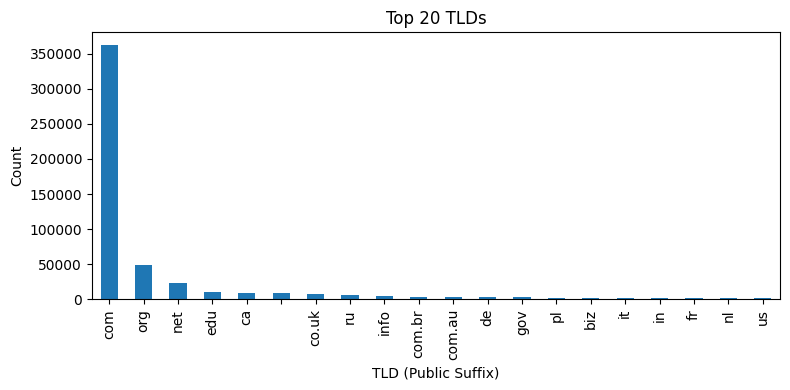

In [5]:
# 1) Label distribution
label_counts = df["Label"].value_counts()
plt.figure(figsize=(5,3))
label_counts.plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) URL length distribution (cap at 500 to visualize)
url_lengths = df["URL"].astype(str).str.len()
plt.figure(figsize=(6,3))
plt.hist(np.clip(url_lengths, 0, 500), bins=50)
plt.title("URL Length Distribution (clipped at 500)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 3) Top 20 TLDs
def extract_tld(u):
    ext = tldextract.extract(str(u))
    return (ext.suffix or "").lower()

tld_series = df["URL"].apply(extract_tld)
top_tlds = tld_series.value_counts().head(20)
plt.figure(figsize=(8,4))
top_tlds.plot(kind="bar")
plt.title("Top 20 TLDs")
plt.xlabel("TLD (Public Suffix)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Labels present: ['bad', 'good']
Vectorizing & training...
Training complete. Evaluating...

=== Classification Report ===
              precision    recall  f1-score   support

         bad     0.9715    0.9464    0.9588     31285
        good     0.9789    0.9889    0.9839     78585

    accuracy                         0.9768    109870
   macro avg     0.9752    0.9677    0.9713    109870
weighted avg     0.9768    0.9768    0.9767    109870



<Figure size 400x400 with 0 Axes>

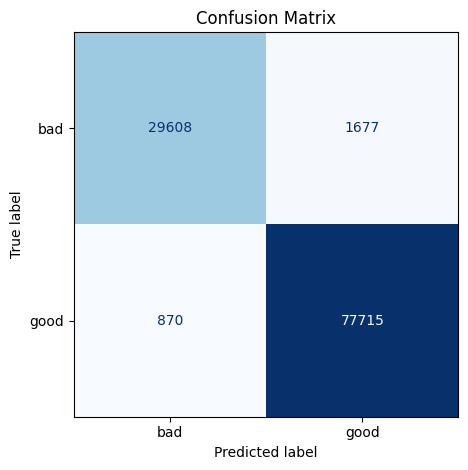


Model saved to: phishing_url_model.joblib | Total elapsed: 148.11s


In [6]:
def train_and_evaluate(df, model_path="phishing_url_model.joblib"):
    df = df.copy()
    df["Label"] = df["Label"].astype(str).str.strip().str.lower()

    uniques = sorted(df["Label"].unique().tolist())
    print("Labels present:", uniques)

    t0 = time.perf_counter()

    # one-class fallback
    if len(uniques) < 2:
        print("Only one class found. Training ONE-CLASS model (IsolationForest).")
        model = make_oneclass_pipeline()
        model.fit(df[["URL"]])
        dump(model, model_path)
        print(f"Model saved to: {model_path} | Elapsed: {time.perf_counter()-t0:.2f}s")
        print("Prediction: -1 = anomaly (likely phishing), 1 = normal.")
        return model, "oneclass"

    # supervised
    X_train, X_test, y_train, y_test = train_test_split(
        df[["URL"]], df["Label"], test_size=0.2, random_state=42, stratify=df["Label"]
    )

    model = make_supervised_pipeline()
    print("Vectorizing & training...")
    model.fit(X_train, y_train)
    print("Training complete. Evaluating...")

    y_pred = model.predict(X_test)

    # Report
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix + heatmap
    cm = confusion_matrix(y_test, y_pred, labels=sorted(df["Label"].unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df["Label"].unique()))
    plt.figure(figsize=(4,4))
    disp.plot(cmap="Blues", values_format="d", colorbar=False)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Save model
    dump(model, model_path)
    print(f"\nModel saved to: {model_path} | Total elapsed: {time.perf_counter()-t0:.2f}s")
    return model, "supervised"

model, mode = train_and_evaluate(df, model_path="phishing_url_model.joblib")


In [ ]:
SAFE_DOMAINS = {
    "google.com","wikipedia.org","microsoft.com","amazon.com",
    "apple.com","paypal.com","facebook.com","netflix.com","adobe.com"
}
def registered_domain(url):
    e = tldextract.extract(str(url))
    return (e.top_domain_under_public_suffix or "").lower()

def postprocess_whitelist(df_preds):
    # df_preds columns: URL, prediction
    rd = df_preds["URL"].apply(registered_domain)
    is_safe = rd.isin(SAFE_DOMAINS)
    df_preds.loc[is_safe, "prediction"] = "good"
    return df_preds

def predict_urls(model_path, urls, mode="supervised", apply_whitelist=True):
    model = load(model_path)
    X = pd.DataFrame({"URL": urls})
    if mode == "oneclass":
        preds = model.predict(X) 
        out = pd.DataFrame({"URL": urls, "prediction": np.where(preds==-1, "bad", "good")})
        return out
    else:
        preds = model.predict(X)
        out = pd.DataFrame({"URL": urls, "prediction": preds})
        return postprocess_whitelist(out) if apply_whitelist else out

# Try a quick demo:
demo_urls = [
    "http://paypal.com.verify-login.example.com/secure/update",
    "https://accounts.google.com/",
    "http://203.0.113.15/login/confirm?user=abc",
    "https://www.wikipedia.org/",
]
predict_urls("phishing_url_model.joblib", demo_urls, mode=mode)


,URL,prediction
0,http://paypal.com.verify-login.example.com/sec...,bad
1,https://accounts.google.com/,good
2,http://203.0.113.15/login/confirm?user=abc,bad
3,https://www.wikipedia.org/,good
